# Task 1 - implement pretrained model + data loader
**Steps**
- Select an image classification problem and a pre-trained model.
- Select testing dataset
- Implement model download.
- Implement testing dataset download.
- Implement `DataLoader` & `DataSet`.
- Implement running the model & threshold mechanism.
- Implement running the model on all test data and calculating statistics + F1.
- Test the model on some random images.

**Important terms:**
- batch - a set of data points processed together.
- Dataset - a collection of data, a class that provides structure and methods to manipulate and access data.
- DataLoader - a class that automates the process of loading data.
- workers - parallel threads used to load and preprocess data.
- pre-fetching/caching - loading data into memory before it is actually needed, this reduces wait times.

## Imports

In [1]:
import torch # Base ML library

from transformers import AutoModelForImageClassification, AutoFeatureExtractor # For downloading the model
from openimages.download import download_dataset # For downloading image dataset
# For reading and transforming images:
from skimage import io
from skimage.transform import resize
from skimage.color import gray2rgb
import glob # For getting the paths of all images


import requests # For downloading images from the web
from PIL import Image# For reading images downloaded from the web

import matplotlib.pyplot as plt # For displaying images

# Extra helper functions:
import math
from IPython.display import clear_output
from collections import defaultdict
import os

## Model Download & Model Running Functions

In [2]:
class ModelManager():
    def __init__(self) -> None:
        self._model = AutoModelForImageClassification.from_pretrained("Falcom/animal-classifier")
        self._feature_extractor = AutoFeatureExtractor.from_pretrained("Falcom/animal-classifier")

    def predict(self, image:torch.Tensor, threshold:float=0.1) -> str:
        probabilities = self._predict_probabilites(image)
        max_probability, id = self._max_class(probabilities)
        if max_probability >= threshold:
            class_name = self._logit_id_to_class(id)
        else:
            class_name = "< threshold"
        return class_name
    
    def extract_features(self, images):
        return self._feature_extractor(images=images, return_tensors="pt")['pixel_values'][0]
    
    def _predict_probabilites(self, image:torch.Tensor) -> torch.Tensor:
        with torch.no_grad():
            logits = self._model(image.unsqueeze(0)).logits
        probabilities = torch.nn.functional.softmax(logits, dim=1)
        return probabilities
    
    def _max_class(self, probabilities:torch.Tensor) -> tuple[float, int]:
        id = probabilities.argmax(-1).item()
        max_probability = probabilities[0, id].item()
        return (max_probability, id)

    def _logit_id_to_class(self, id:int) -> str:
        return self._model.config.id2label[id]

model_manager = ModelManager()

## Test Data Download
**Delete data directory to redownload images.**

In [3]:
class TestData():
    def __init__(self, images_dir_path, classes, samples_per_class) -> None:
        self.images_dir_path = images_dir_path
        self.samples_per_class = samples_per_class
        if not os.path.isdir(self.images_dir_path):
            download_dataset(images_dir_path, classes, limit=samples_per_class)
        self.classes = [string.lower() for string in classes]

# Cow fails to download
test_data = TestData("./data", ["Dog", "Cat", "Butterfly", "Chicken", "Elephant", "Horse", "Sheep", "Spider", "Squirrel"], 111)

## DataSet

In [4]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, images_dir_path:str, classes:list[str], transform=None) -> None:
        self.images_dir_path = images_dir_path
        self.classes = classes
        self.transform = transform

        self.all_image_paths = [] # X, in the form of image paths
        self.all_labels = [] # Y, in the form of class name strings

        # Get all file paths and create labels for them
        for class_ in classes:
            image_paths = glob.glob(self.images_dir_path + "/{}/images/*.jpg".format(class_))
            self.all_labels += [class_] * len(image_paths)
            self.all_image_paths += image_paths
        # No need for shuffle as data loader has this functionality

    
    def __len__(self):
        return len(self.all_image_paths)

    def __getitem__(self, index):
        image_path = self.all_image_paths[index]
        image = self.read_image(image_path)
        label = self.all_labels[index]
        return (image, label)
    
    def read_image(self, image_path):
        image = io.imread(image_path)
        # This is needed because some images are grayscale and dont have C dimension (feature extractor doesnt handle this).
        if image.ndim == 2:
            image = gray2rgb(image)
        # I have to use feature extractor here, because rescaling twice makes image black, which leads to model only predicting dog.
        # And rescaling must happen here, because data loader expects all data to be of the same size.
        image = model_manager.extract_features(image)
        return image

dataset = CustomDataset(test_data.images_dir_path, test_data.classes)

## Run All Test Data

In [5]:
def run_test_data(model_manager:ModelManager, dataset:CustomDataset):
    batch_size = 7
    test_data = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    true_predictions = defaultdict(int)
    false_predictions = defaultdict(int)
    label_counts = defaultdict(int)
    total_examples = len(dataset)

    current_iteration = 0
    total_iterations = math.ceil(total_examples/batch_size)

    for (images, labels) in test_data:
        print("Iteration: ", current_iteration, "/", total_iterations)
        for (image, label) in zip(images, labels):
            label_counts[label] += 1
            prediction = model_manager.predict(image)
            if prediction == label:
                true_predictions[prediction] += 1
            else:
                false_predictions[prediction] += 1
        clear_output(wait=True)
        current_iteration += 1

    print("Finished the epoch.")
    return true_predictions, false_predictions, label_counts

true_predictions, false_predictions, label_counts = run_test_data(model_manager, dataset)

Finished the epoch.


## Calculate Statistics
- Positive - the positive class prediction, are we predicting positive class?
- Negative - the negative class prediction, are we predicting negative class?
- True - prediction outcome, prediction == label
- False - prediction outcome, prediction != label
- **TP** True Positive - predicted positive, actually positive.
- **FP** False Positive - predicted positive, actually negative.
- **TN** True Negative - predicted negative, actually negative.
- **FN** False Negative - predicted negative, actually positive (or other negative in a multiclass single label problem).

**accuracy = (TN + TP)/(TP+TN+FP+FN)**

**Accuracy is a bad measurment when our test dataset is biased** - when we have more examples of one class than the other.

**precision = TP/TP+FP**

Precision - the percentage of positive guesses that were true.

**recall = TP/TP+FN**, **TP+FN** - is the total number of positive examples.

Recall - the percentage of positive test examples we are actually classifying as positive.

F1 - a middle ground between precision and recall.

**F1 = (2 * precision * recall)/(precision + recall)**

In [14]:
def claculate_statistics():
    for c_name in test_data.classes:
        TP = true_predictions[c_name]
        TN = sum(true_predictions.values()) - TP
        FP = false_predictions[c_name]
        FN = sum(false_predictions.values()) - FP

        accuracy = (TP + TN) / (TP + TN + FP + FN)
        precision = TP / (TP + FP)
        recall = TP / label_counts[c_name] # Adaptation for a multiclass single label problem.
        f1 = (2 * precision * recall)/(precision + recall)

        print("Class:", c_name.upper())
        print("precision: ", "{:.2f}".format(precision))
        print("recall: ", "{:.2f}".format(recall))
        print("f1: ", "{:.2f}".format(f1))
        print("")
    print("accuracy: ", "{:.2f}".format(accuracy))

claculate_statistics()

Class: DOG
precision:  0.70
recall:  0.83
f1:  0.76

Class: CAT
precision:  0.92
recall:  0.65
f1:  0.76

Class: BUTTERFLY
precision:  0.89
recall:  0.92
f1:  0.91

Class: CHICKEN
precision:  0.93
recall:  0.85
f1:  0.89

Class: ELEPHANT
precision:  0.97
recall:  0.95
f1:  0.96

Class: HORSE
precision:  0.87
recall:  0.92
f1:  0.89

Class: SHEEP
precision:  0.89
recall:  0.98
f1:  0.94

Class: SPIDER
precision:  0.96
recall:  0.96
f1:  0.96

Class: SQUIRREL
precision:  0.94
recall:  0.93
f1:  0.93

accuracy:  0.89


## Plot Image Function

In [11]:
def plot_image(image):
    reformated_image = image.permute(2, 1, 0) # [C,H,W] -> [H,W,C]
    plt.imshow(reformated_image)

# Test Model On Your Image

2024-02-18  19:14:31 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


class:  CAT
richard-3.jpg


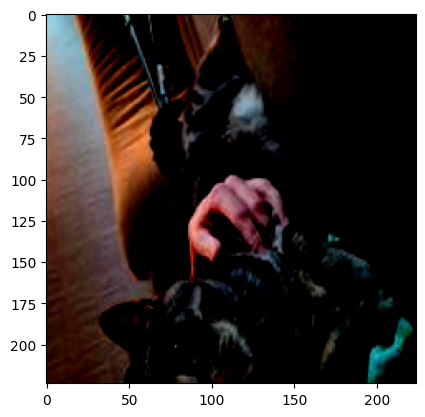

In [8]:
def test_your_image(your_image_name):
    image = io.imread("./your_images/" + your_image_name)
    image = model_manager.extract_features(image)

    prediction = model_manager.predict(image)

    print("class:", prediction.upper())
    print(your_image_name)
    plot_image(image)

test_your_image("richard-3.jpg")

## Test Image From The Web

2024-02-18  19:14:32 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Model prediction for this image:  cat


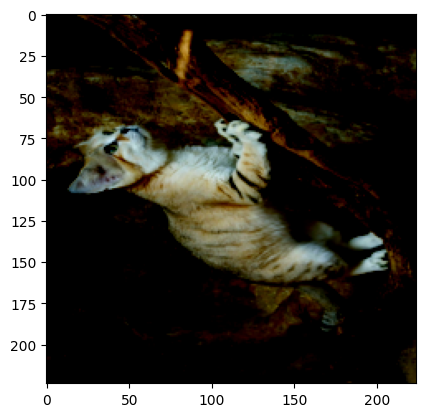

In [9]:
def test_web_image(model_manager:ModelManager, url=""):
    if(url==""):
        print("Empty url.")
        return
    
    image = Image.open(requests.get(url, stream=True).raw)
    image = model_manager.extract_features(image)

    prediction = model_manager.predict(image)

    print("Model prediction for this image: ", prediction)
    plot_image(image)

test_web_image(model_manager, 'https://nationalzoo.si.edu/sites/default/files/animals/sandcat-002.jpg')

## Model Metrics
Metrics are based on 999 images from **openimages**. Please note, that one class that the model predicts `cow` is missing from the test data set. Therefore, the average precision is slightly higher than recall.

### Overall Average
- **Precision: 0.897**
- **Recall: 0.888**
- **F1 score: 0.888**


### Class: DOG
- Precision: 0.70
- Recall: 0.83
- F1 Score: 0.76

### Class: CAT
- Precision: 0.92
- Recall: 0.65
- F1 Score: 0.76

### Class: BUTTERFLY
- Precision: 0.89
- Recall: 0.92
- F1 Score: 0.91

### Class: CHICKEN
- Precision: 0.93
- Recall: 0.85
- F1 Score: 0.89

### Class: ELEPHANT
- Precision: 0.97
- Recall: 0.95
- F1 Score: 0.96

### Class: HORSE
- Precision: 0.87
- Recall: 0.92
- F1 Score: 0.89

### Class: SHEEP
- Precision: 0.89
- Recall: 0.98
- F1 Score: 0.94

### Class: SPIDER
- Precision: 0.96
- Recall: 0.96
- F1 Score: 0.96

### Class: SQUIRREL
- Precision: 0.94
- Recall: 0.93
- F1 Score: 0.93

### Overall Accuracy
- Accuracy: 0.89
